## Smith-Hutton Problem

We want to solve the following PDE:

\begin{equation}
    u \frac{\partial \phi}{\partial x} + v \frac{\partial \phi}{\partial y} = \Gamma (\phi_{xx} + \phi_{yy}) 
\end{equation}

The independen variables, $x$ and $y$, and the diffusive constant, $\Gamma$, are used as input values for the NN, and the solution (i.e. $\phi(x,y)$) is the output. In order to find the solution, at each step the NN outputs are derived w.r.t the inputs to obtain the first order derivatives. The same is done for the gradients to obtain the second order derivatives. Then, a loss function that matches the PDE is built and the weights are updated accordingly. A loss function that matches the PDE is then used for optimization. If the loss function goes to zero, we can assume that our NN is indeed the solution to our PDE. We will try to find a general solution for different values of $\Gamma$, so we can then obtain a solution for different diffusivities without requiring new computations. The geometry of the problem is as follows:

![sh](pics/sh.png)

In [ ]:
# autoreload nangs
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
#imports
import math
import numpy as np 
import matplotlib.pyplot as plt 

import torch
cuda = True
device = "cuda" if torch.cuda.is_available() and cuda else "cpu"

First we define our PDE and set the values for training.

In [ ]:
from nangs.pde import PDE
from nangs.bocos import PeriodicBoco, DirichletBoco, NeumannBoco

class MyPDE(PDE):
    def __init__(self, inputs=None, outputs=None, order=2):
        super().__init__(inputs, outputs, order=order)
    def computePDELoss(self, grads, inputs, params): 
        dpdx, dpdy = grads['p']['x'], grads['p']['y']
        d2pdx2, d2pdy2 = grads['2p']['xx'], grads['2p']['yy']
        x, y = inputs['x'], inputs['y']
        u, v = 2*y*(1-x**2), -2*x*(1-y**2)
        return u*dpdx + v*dpdy - inputs['g']*(d2pdx2 + d2pdy2)

# instanciate pde
pde = MyPDE(inputs=['x', 'y', 'g'], outputs=['p'])

# define input values
x = np.linspace(-1,1,60)
y = np.linspace(0,1,30)
g = np.array([0.1, 0.001, 0.000001])

pde.setValues({'x': x, 'y': y, 'g': g})
pde.setValues({'x': x, 'y': y, 'g': g}, train=False)

Boundary conditions.

In [ ]:
# alpha parameter
a = 10

# left and rigth b.c 
x1, x2 = np.array([-1, 1]), np.array([1])
p = np.zeros(2*len(y)*len(g))
for i in range(2*len(y)): 
    for _g in g:
        p[i] = 1. - math.tanh(a)
boco = DirichletBoco('left_right', {'x': x1, 'y': y, 'g': g}, {'p': p})
pde.addBoco(boco)

# top b.c 
y2 = np.array([1])
p = np.zeros(len(x)*len(g))
for i in range(len(x)): 
    for _g in g:
        p[i] = 1. - math.tanh(a)
boco = DirichletBoco('top', {'x': x, 'y': y2, 'g': g}, {'p': p})
pde.addBoco(boco)

# bottom b.c
y1 = np.array([0])
x1, x2, p1 = [], [], []
for i in range(len(x)): 
    if x[i] < 0:
        x1.append(x[i])
    else:
        x2.append(x[i])
for _g in g:
    for i in range(len(x)): 
        if x[i] < 0:
            p1.append(1.+math.tanh(a*(2*x[i]+1)))
x1, x2, p1 = np.array(x1), np.array(x2), np.array(p1) 

# bottom left b.c
boco = DirichletBoco('bottom_left', {'x': x1, 'y': y1, 'g': g}, {'p': p1})
pde.addBoco(boco)

# bottom right b.c
boco = NeumannBoco('bottom_right', {'x': x2, 'y': y1, 'g': g}, grads={'p': 'y'})
pde.addBoco(boco)

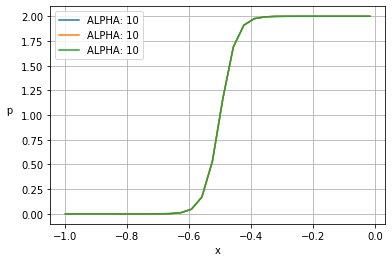

In [ ]:
# visualize inlet conditions (same ALPHA for every Gamma)
n, m = len(g), len(x1)
for i in range(n):
    plt.plot(x1,p1[i*m:(i+1)*m], label="ALPHA: {}".format(a))
plt.legend()
plt.grid()
plt.xlabel("x")
plt.ylabel("p    ", rotation=np.pi/2)
plt.show()

Now we define a topology for our solution and set the training parameters. Then we can find a solution for our PDE.

In [ ]:
# define solution topology
topo = {'layers': 5, 'neurons': 2048, 'activations': 'sigmoid'}
pde.buildSolution(topo)

# set optimization parameters
pde.compile(epochs=100, lr=3e-4, batch_size=32)

In [ ]:
# find the solution
hist = pde.solve(device, 'sh_diff_best.pth') 

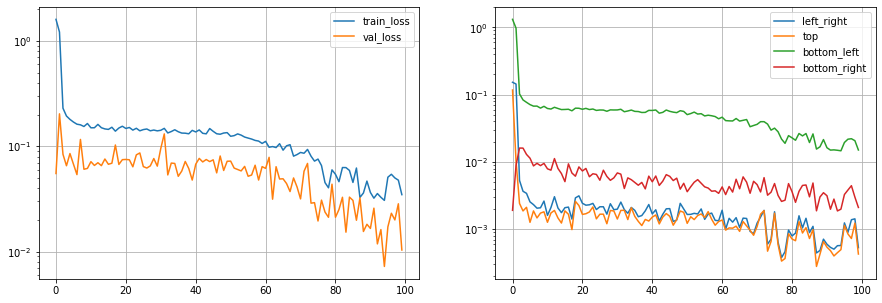

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
ax1.plot(hist['train_loss'], label="train_loss")
ax1.plot(hist['val_loss'], label="val_loss")
ax1.grid(True)
ax1.legend()
ax1.set_yscale("log")
for boco in pde.bocos:
    ax2.plot(hist['bocos'][boco.name], label=boco.name)
ax2.legend()
ax2.grid(True)
ax2.set_yscale("log")
plt.show()

Finally, we can evaluate our solution.

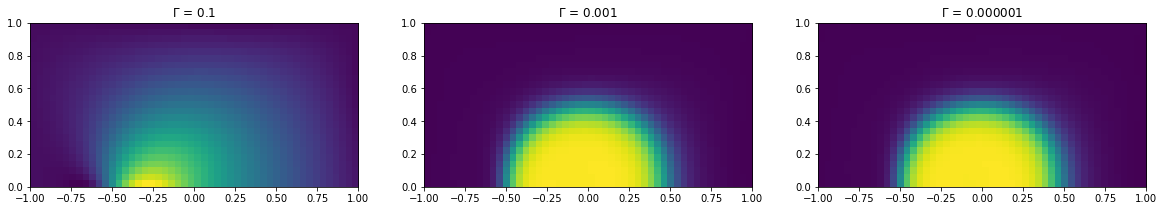

In [ ]:
# evaluate the solution
pde.load_state_dict('sh_diff_best.pth')
x = np.linspace(-1,1,50)
y = np.linspace(0,1,25)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,60))
g = np.array([0.1])
p1 = pde.evaluate({'x': x, 'y': y, 'g': g}, device)
ax1.imshow(p1.reshape((len(y),len(x))), vmin=p1.min(), vmax=p1.max(), origin='lower',
           extent=[x.min(), x.max(), y.min(), y.max()])
ax1.set_title(f"$\\Gamma$ = 0.1")
g = np.array([0.001])
p2 = pde.evaluate({'x': x, 'y': y, 'g': g}, device)
ax2.imshow(p2.reshape((len(y),len(x))), vmin=p2.min(), vmax=p2.max(), origin='lower',
           extent=[x.min(), x.max(), y.min(), y.max()])
ax2.set_title(f"$\\Gamma$ = 0.001")
g = np.array([0.000001])
p3 = pde.evaluate({'x': x, 'y': y, 'g': g}, device)
ax3.imshow(p3.reshape((len(y),len(x))), vmin=p3.min(), vmax=p3.max(), origin='lower',
           extent=[x.min(), x.max(), y.min(), y.max()])
ax3.set_title(f"$\\Gamma$ = 0.000001")
#plt.colorbar()
plt.show()

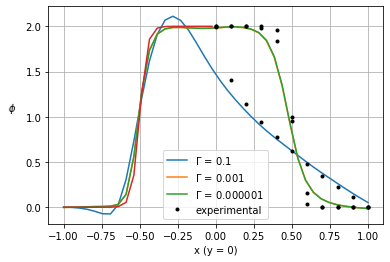

In [ ]:
# experimental results
exp = {
    'x': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'g_0.1': [1.989,1.402,1.146,0.946,0.775,0.621,0.480,0.349,0.227,0.111,0.0],
    'g_0.001': [2.0000,1.9990,1.9997,1.985,1.841,0.951,0.154,0.001,0.0,0.0,0.0],
    'g_0.000001': [2.0000,2.0,2.0,1.999,1.964,1.0,0.036,0.001,0.0,0.0,0.0]
}

x = np.linspace(-1,1,40)
y = np.array([0])
p = pde.evaluate({'x': x, 'y': y, 'g': np.array([0.1])}, device)
plt.plot(x,p, label=f"$\\Gamma$ = 0.1")
p = pde.evaluate({'x': x, 'y': y, 'g': np.array([0.001])}, device)
plt.plot(x,p, label=f"$\\Gamma$ = 0.001")
p = pde.evaluate({'x': x, 'y': y, 'g': np.array([0.000001])}, device)
plt.plot(x,p, label=f"$\\Gamma$ = 0.000001")

x1, p1, gamma = [], [], 0.1
for i in range(len(x)): 
    if x[i] < 0:
        x1.append(x[i])
        p1.append(1.+math.tanh(a*(2*x[i]+1)))
x1, p1 = np.array(x1), np.array(p1)
plt.plot(x1,p1)

plt.plot(exp['x'], exp['g_0.1'], '.k')
plt.plot(exp['x'], exp['g_0.001'], '.k')
plt.plot(exp['x'], exp['g_0.000001'], '.k', label="experimental")
plt.grid()
plt.xlabel('x (y = 0)')
plt.ylabel('$\\phi$       ', rotation=np.pi/2)
plt.legend()
plt.show()